# load library

In [1]:
source("r/jupyter_common.R")

source("r/enrichment_analysis.R")
source("r/find_markers.R")
source("r/identify_cell_types.R")
source("r/plot_sc_clusters.R")


In [2]:
# data structure
suppressPackageStartupMessages(library(stringi))
suppressPackageStartupMessages(library(forcats))

# utils
suppressPackageStartupMessages(library(amap)) # for Dist()
suppressPackageStartupMessages(library(scales))

# scRNA-seq
suppressPackageStartupMessages(library(Seurat))



## parallel

In [3]:
suppressPackageStartupMessages(library(future))
plan("multicore", workers = 8)

options(future.globals.maxSize = 5 * 1024^3) # 5GB


# parameters

In [4]:
cancer_type <- "er+bc-cell-line"


args <- list()
args$cancer_type <- cancer_type
args$method_to_identify_cell_types <- "singler_blueprint_encode"
args$seurat_resolution <- 0.8
args$harmony_theta <- 0

str_column_of_meta_data_cluster <- sprintf("RNA_snn_res.%g", args$seurat_resolution)
str_column_of_meta_data_harmony <- sprintf("RNA_harmony_th.%s", paste(args$harmony_theta, collapse=","))

str_reduction <- "pca"
str_umap_reduction <- "umap"  
col_cluster_types <- "cluster.type"

str_condition <- cancer_type

str_condition
str_column_of_meta_data_cluster
str_umap_reduction
col_cluster_types

figure_format <- "pdf"




[1] "er+bc-cell-line"

[1] "RNA_snn_res.0.8"

[1] "umap"

[1] "cluster.type"

## set.seed

In [5]:
# set seed for reproducibility
set.seed(51)



## display

In [6]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=50)


## nv_cell_type_conversion_table

In [7]:
nv_cell_type_conversion_table <- c(
            "Epithelial cells"="Epi. CNA-",
            "Normal-like"="Normal-like",
            "Basal"="Basal",
            "Her2"="Her2",
            "LumA"="grpA",
            "LumB"="grpB")


# read scRNA-seq

In [8]:

dir_rna <- "/home/hkim77/spanheimer_lab.w/sc-rna-seq/tr-bc/run-20220121"
fname_rna <- sprintf("%s/output/rds_%s/%s_sc-rna-seq_merged_seurat_obj.rds",
                     dir_rna, cancer_type, cancer_type)
fname_rna

rna <- readRDS(fname_rna)



[1] "/home/hkim77/spanheimer_lab.w/sc-rna-seq/tr-bc/run-20220121/output/rds_er+bc-cell-line/er+bc-cell-line_sc-rna-seq_merged_seurat_obj.rds"

## n_samples

In [9]:
samples <- unique(rna@meta.data$Sample)
samples

n_samples <- length(samples)
n_samples


[1] "T47D_Control"   "T47D_Tamoxifen"

[1] 2

## list_samples

In [10]:
list_samples <- list()

idx <- grep("Control", samples)
u_samples <- gsub("_Control", "", samples[idx])
for (sample in u_samples) {
    list_samples[[sample]]$control <- sprintf("%s_Control", sample)
    list_samples[[sample]]$treatment <- sprintf("%s_Tamoxifen", sample)
}

list_samples
length(list_samples)

$T47D
$T47D$control
[1] "T47D_Control"

$T47D$treatment
[1] "T47D_Tamoxifen"

[1] 1

## mtx

In [11]:
if (DefaultAssay(rna) == "integrated") {
    mtx <- GetAssayData(object = rna, assay=NULL, slot = "data")
} else {
    mtx <- GetAssayData(object = rna, assay="RNA", slot = "data")
}


## list_sort

In [12]:

list_sort <- sort_cluster_members(rna, args,
                    col_cluster_types = col_cluster_types,
                    str_umap_reduction = str_umap_reduction,
                    f_merge_immune_cell = FALSE)


## colors

### samples

[1] "#A6CEE3" "#FB9A99" "#1F78B4" "#E31A1C"

[1] 4

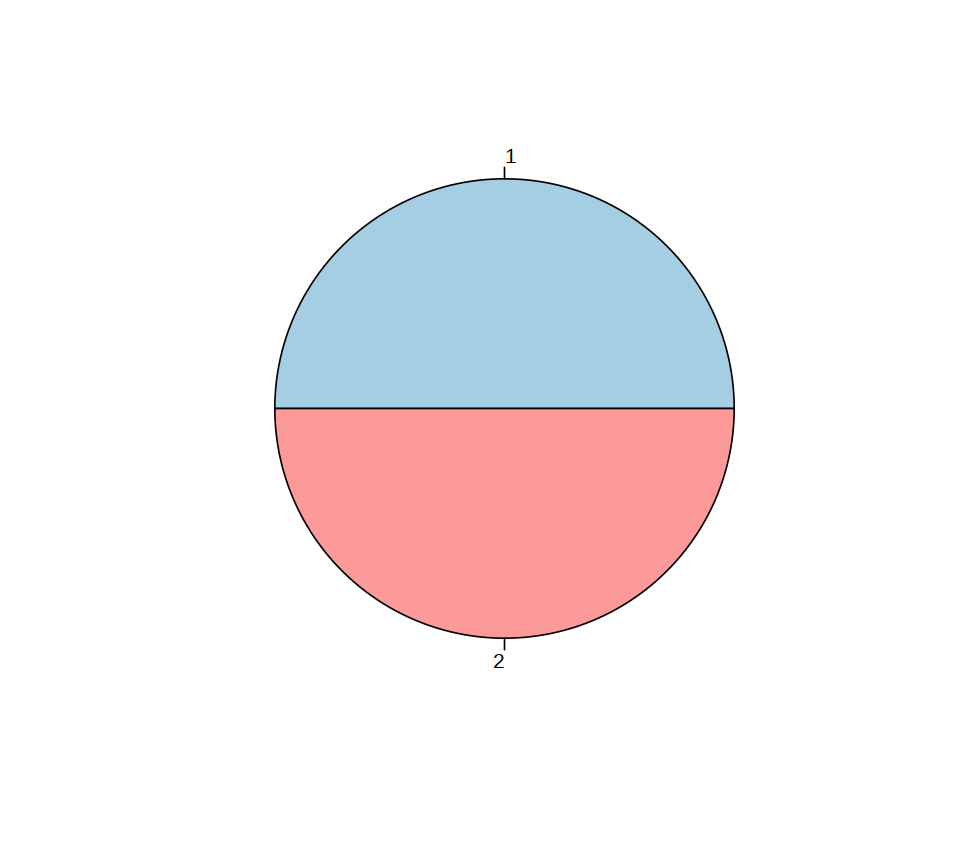

In [13]:
# make patient sample metadata and color assignments 
# http://applied-r.com/rcolorbrewer-palettes/

if (n_samples <= 4) {
    sampleColors <- brewer.pal(12, "Paired")
    sampleColors <- sampleColors[c(1,5,2,6)]
} else if (n_samples <= 12){
    sampleColors <- brewer.pal(n_samples, "Paired")
} else {
    vec_color1 <- colorRampPalette(brewer.pal(9, "Set1"))(n_samples/2)
    vec_color2 <- colorspace::lighten(vec_color1, amount=0.4) 
    sampleColors <- c(rbind(vec_color1, vec_color2))
}

sampleColors
length(sampleColors)

options(repr.plot.width=8.01, repr.plot.height=7.01)
pie(rep(1,n_samples), col=sampleColors) 


### epi

[1] "Epithelial cells" "Epi. Non-tumor"   "LEp_prog"         "LEp_secretory"   
 [5] "LEp"              "LEp_hormone"      "BEp"              "BEp_MaSCs"       
 [9] "BEp_myo"          "Epi. Unassigned"  "Epi. Tumor"       "Normal-like"     
[13] "NBL"              "Basal"            "CLow"             "Her2E"           
[17] "LumA"             "LumB"             "Keratinocytes"

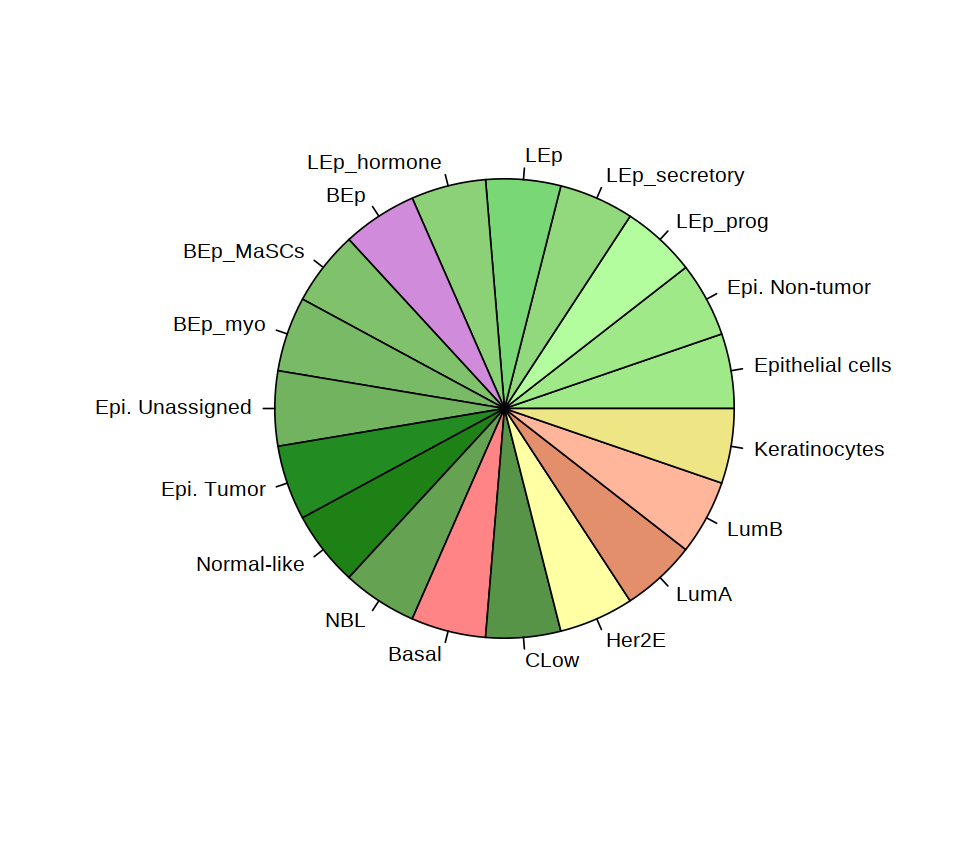

In [14]:
idx_epi <- grep(pattern_epi, names(nv_color))
names(nv_color)[idx_epi]
# http://applied-r.com/rcolorbrewer-palettes/
colors_epi <- RColorBrewer::brewer.pal(9, "Set1")
colors_epi <- colorspace::lighten(colors_epi, amount=0.4)

nv_color["Epi. Tumor"] <- "forestgreen"

nv_color["LEp_prog"] <- "#b4fd9e"
nv_color["LEp"] <- colors_epi[3]
nv_color["BEp"] <- colors_epi[4]

nv_color["Basal"] <- colors_epi[1]
nv_color["Her2E"] <- colors_epi[6]
nv_color["Her2"] <- colors_epi[6]
nv_color["LumA"] <- colors_epi[7]
nv_color["LumB"] <- colors_epi[5]
nv_color["Normal-like"] <- colorspace::darken(colors_epi[3], amount=0.4)

pie(rep(1, length(idx_epi)), col=nv_color[idx_epi],
       labels=names(nv_color)[idx_epi]) 


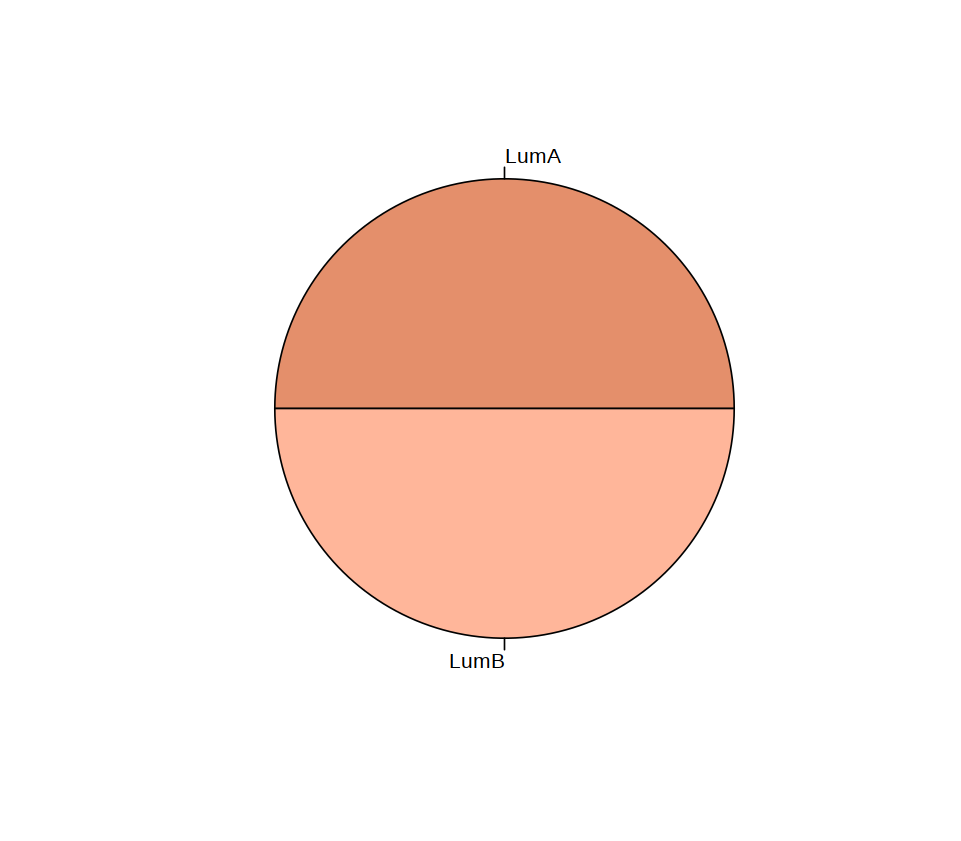

In [15]:
list_sort <- update_nv_color_cell_type(list_sort)
colors_epi <- list_sort$nv_color_cell_type

pie(rep(1, length(colors_epi)), col=colors_epi,
       labels=names(colors_epi)) 


### cell.type

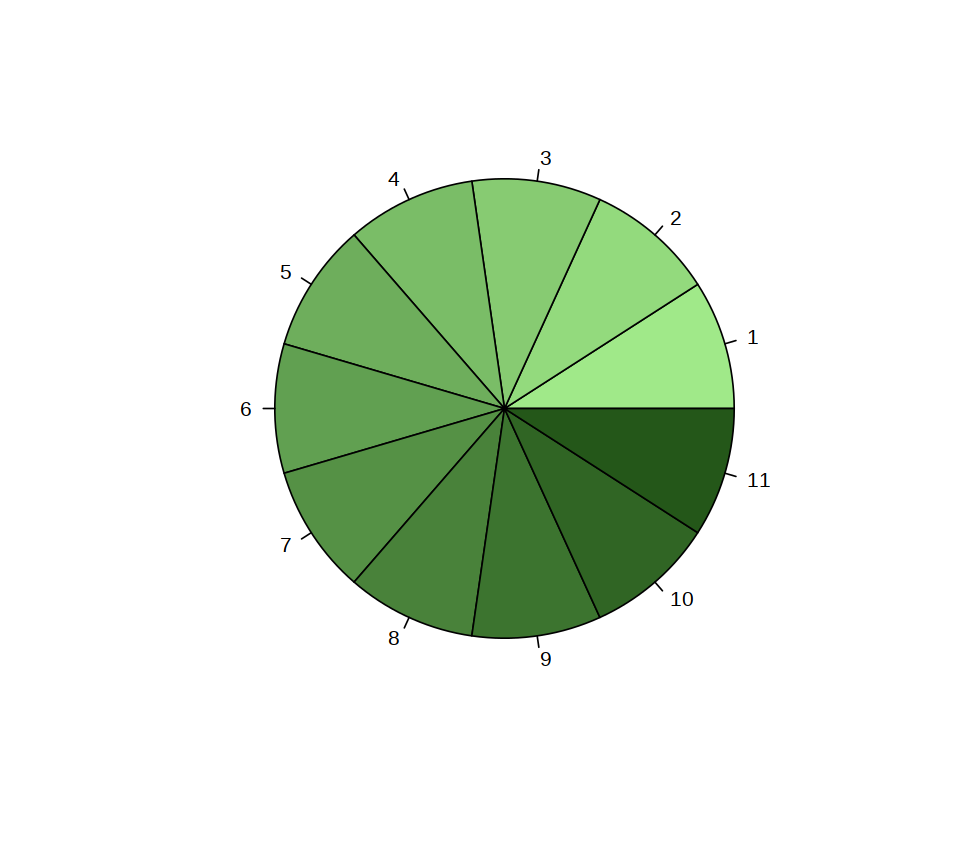

In [16]:
options(repr.plot.width=8.01, repr.plot.height=7.01)
pie(rep(1, length(list_sort$nv_color_cluster_type_ordered)),
    col=list_sort$nv_color_cluster_type_ordered) 


# UMAPs

## samples

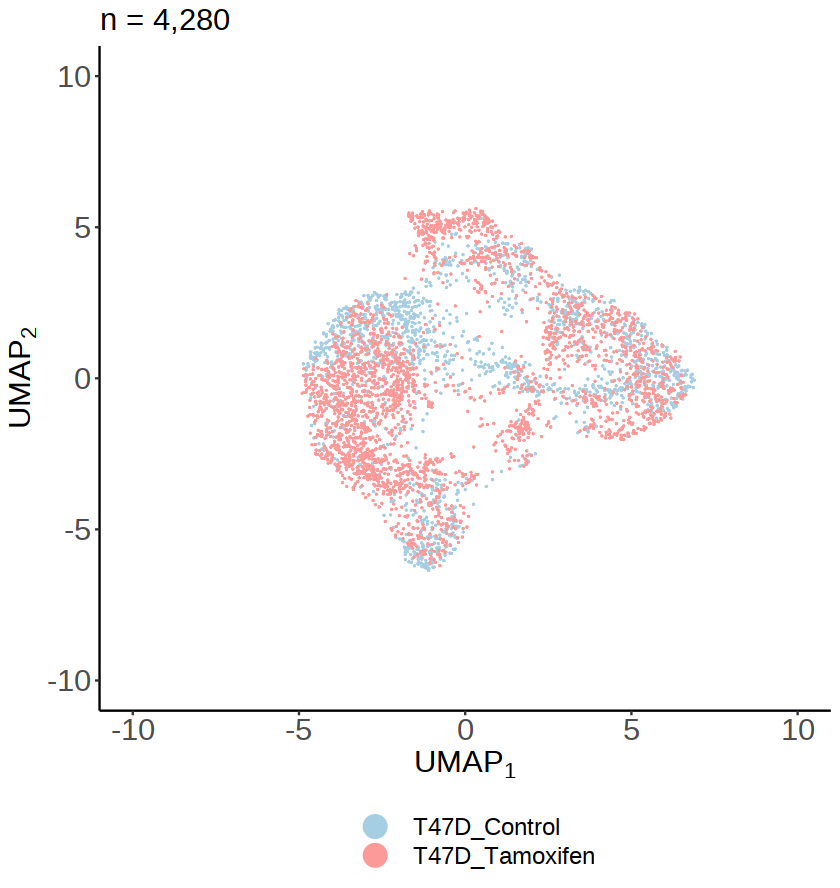

In [17]:

ncol_ <- 2
if (n_samples <= 4) ncol_ <- 1

gg <- print_umap_samples(list_sort,
        colors_samples=sampleColors,
        ncol=ncol_, str_condition=str_condition)


## cluster types

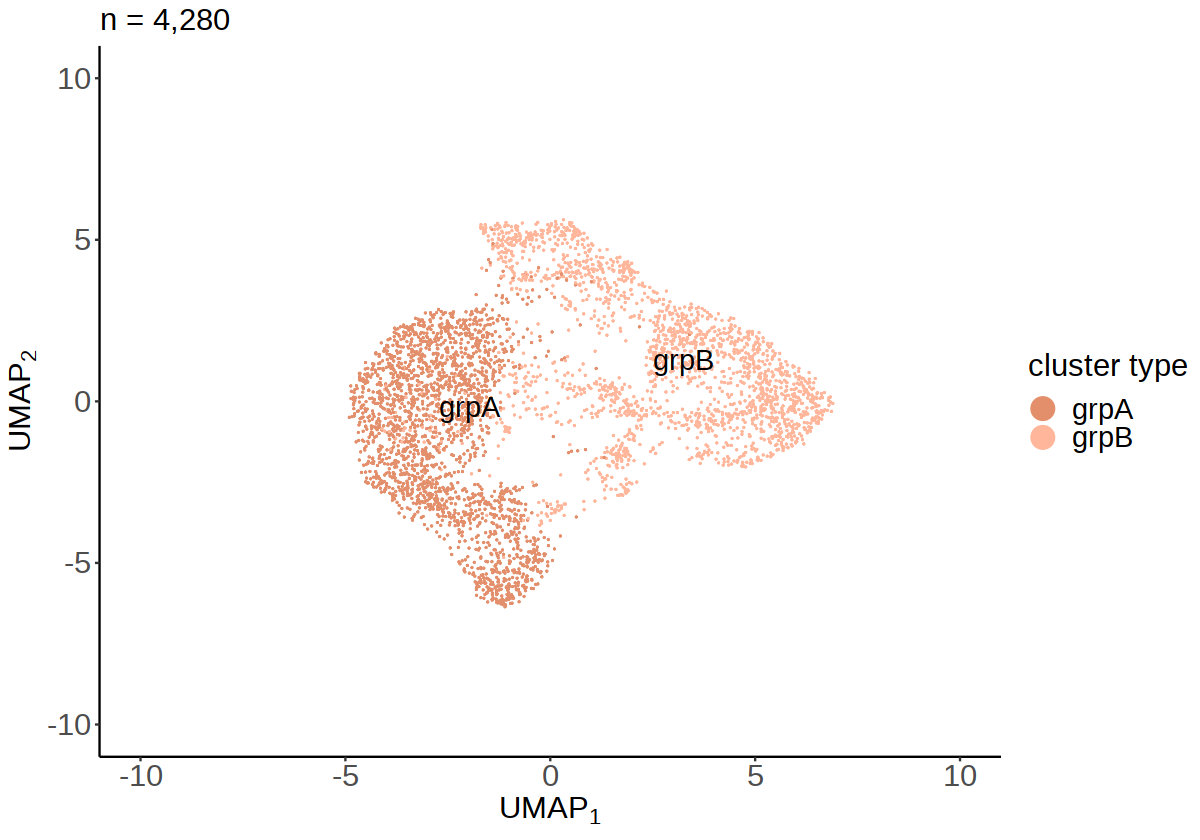

In [18]:

gg <- print_umap_cluster_types(list_sort,
            ncol=1, width=10, height=7,
            str_condition=str_condition)


# markers

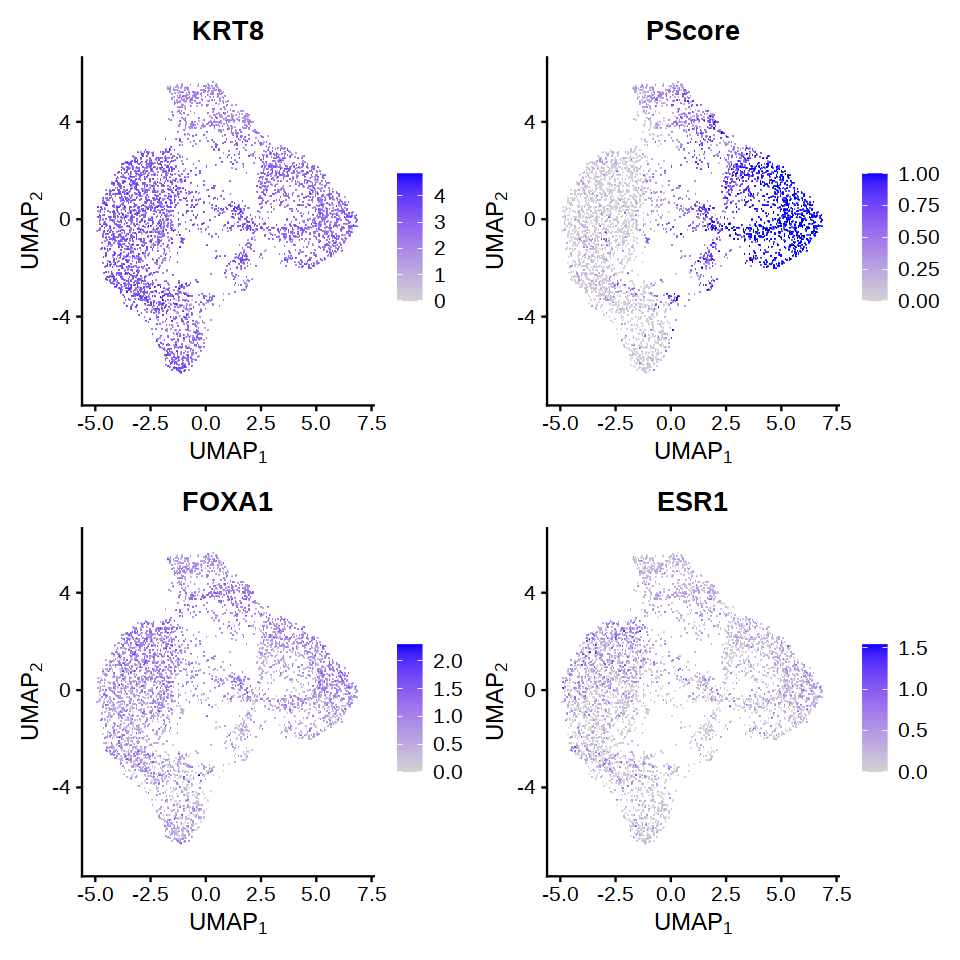

In [19]:

gg <- print_featureplot_markers(rna,
            genes=c("KRT8", "PScore", "FOXA1", "ESR1"),               
            pt.size=1,
            ncol=2,
            width=8, height=8,
            str_condition=str_condition)


# session info

In [20]:
writeLines(capture.output(sessionInfo()), "txt/sessionInfo.txt")


# reference

https://satijalab.org/seurat/

